# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.datasets import fetch_LINEAR_geneva
from astroML.plotting import setup_text_plots
from astroML.plotting import hist
setup_text_plots(fontsize=16, usetex=True)

import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc
from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results
import warnings; warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
%matplotlib inline

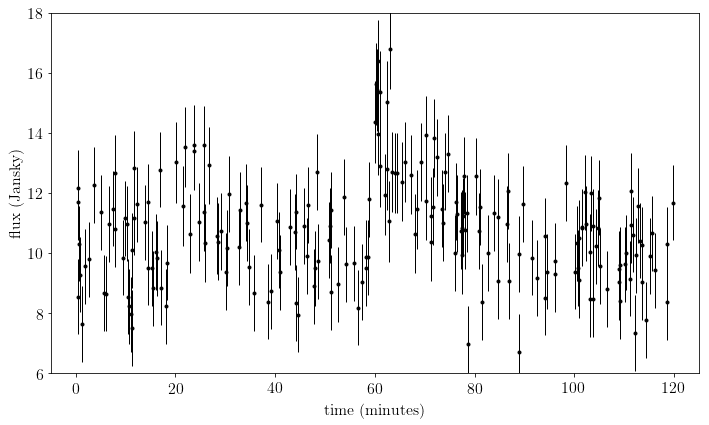

In [2]:

# read data
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(20, 20))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

In [3]:

#----------------------------------------------------------------------
# Set up toy dataset
def model(t,y_obs,sigma_y,b0=None):
    def burst(t, b0, A, alpha, T):
        """Burst model"""
        y = np.empty(t.shape)
        y.fill(b0)
        mask = (t >= T)
        y[mask] += A * np.exp(-alpha * (t[mask] - T))
        return y

    np.random.seed(10)
    N = len(t) 
    sigma=1.0

    #----------------------------------------------------------------------
    # Set up MCMC sampling
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)

    # uniform prior on log(alpha)
    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return 1/np.exp(log_alpha)

    @pymc.deterministic
    def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model, y=y)


    #----------------------------------------------------------------------
    # Run the MCMC sampling
    def compute_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals

    traces, fit_vals = compute_MCMC_results()

    labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
    fig.subplots_adjust(bottom=0.1, top=0.95,
                        left=0.1, right=0.95,
                        hspace=0.05, wspace=0.05)

    obs=[b0,A,T,alpha]

    # This function plots multiple panels with the traces
    plot_mcmc(traces, labels=labels,true_values=obs, fig=fig,
              bins=30, colors='k')

    # Plot the model fit
    ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
    t_fit=t
    y_fit = burst(t_fit, *fit_vals)
    print('\nBurst time:%f'%fit_vals[3])

    ax.scatter(t, y_obs, s=9, lw=0, c='k')
    ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
    ax.plot(t_fit, y_fit, '-k', c='red')
    # ax.set_xlim(0, 100)
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$h_{\rm obs}$')
    plt.axvline(x=T)
    plt.show()
    return y_fit,t_fit,(*fit_vals)



 [-----------------100%-----------------] 25000 of 25000 complete in 4.2 sec
Burst time:20.153150


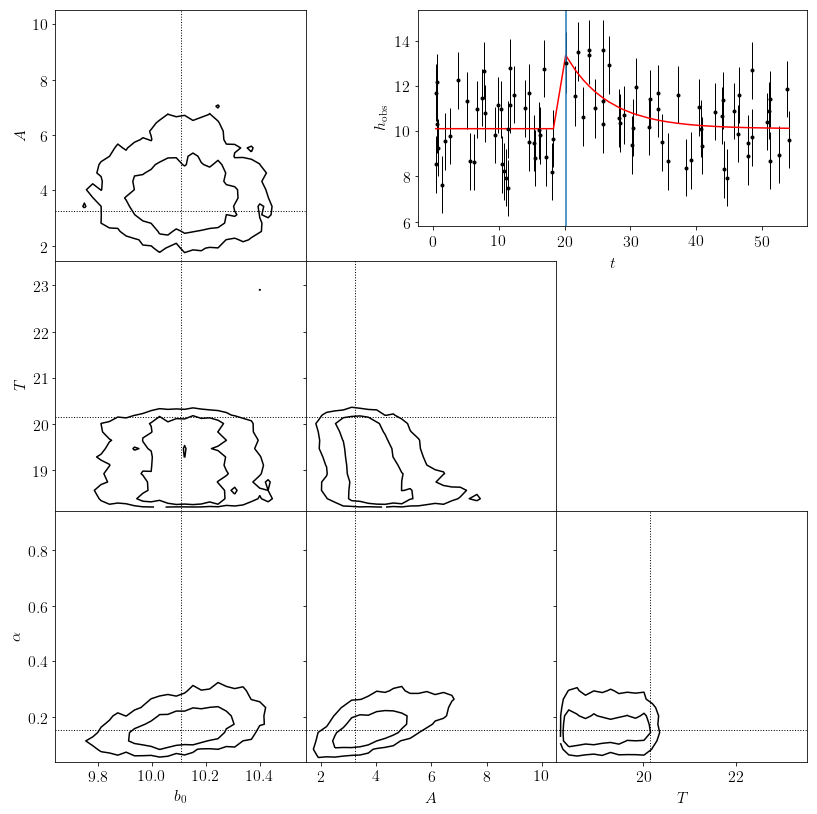

 [-----------------100%-----------------] 25000 of 25000 complete in 5.0 sec
Burst time:59.925934


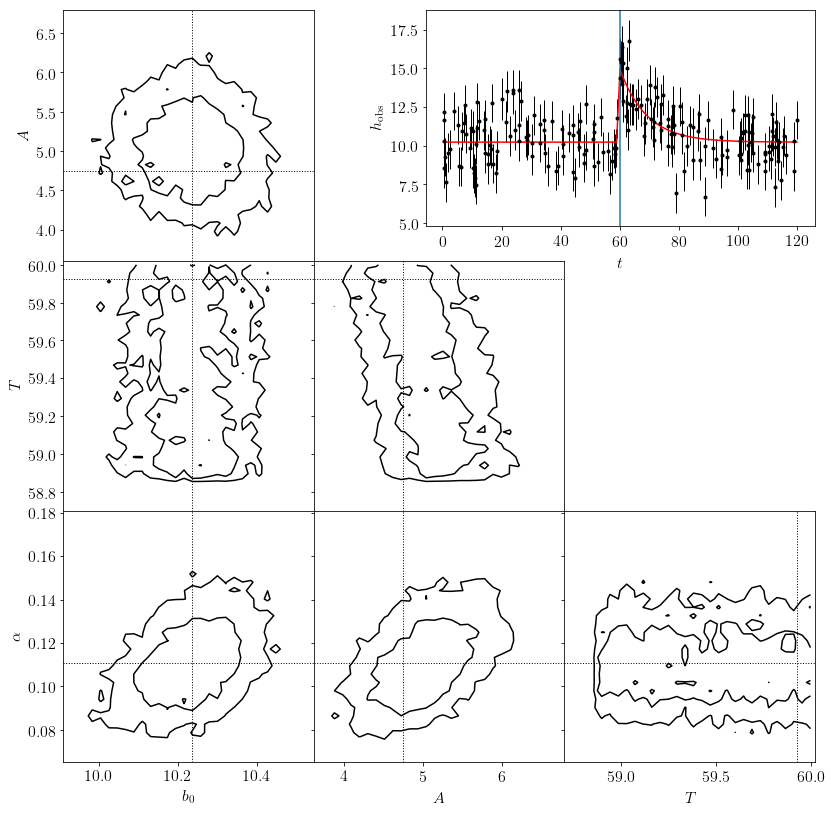

In [4]:

b1_cond=np.where(t<t[y_obs.argmax()]-8)                #region less than global maxima
t1=t[b1_cond]
y_obs_1=y_obs[b1_cond]
sigma_y_1=sigma_y[b1_cond]
burst1,t_fit1,b_01,A_1,alpha_1,T1=model(t1,y_obs_1,sigma_y_1)

                                                        #global range
burst2,t_fit2,b_02,A_2,alpha_2,T2=model(t,y_obs,sigma_y)


Single Burst Model: Chi^2=240.563133  BIC=261.756403
Double Burst Model: Chi^2=214.262784  BIC=235.456054


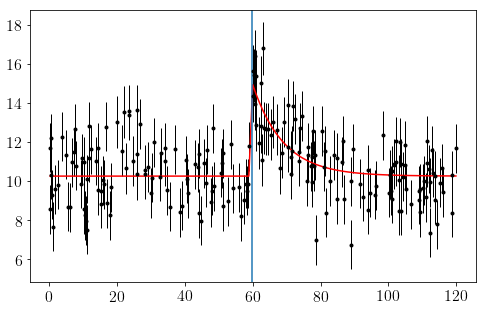

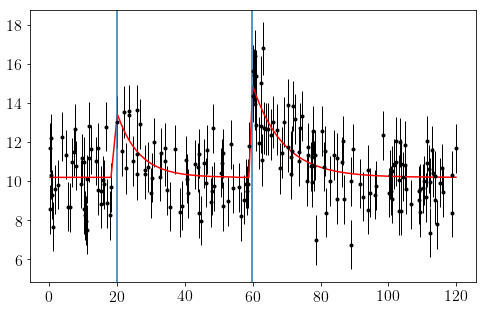

In [5]:
#Single Burst model 
chi2=np.sum(((y_obs-burst2)/sigma_y)**2)
bic=chi2+4*np.log(len(burst2))
print('Single Burst Model: Chi^2=%f  BIC=%f'%(chi2,bic))


burst=np.concatenate((burst1-b_01, burst2[(t_fit2>=t[y_obs.argmax()]-8)]-b_02))+(b_01+b_02)/2
t_fit=np.concatenate((t_fit1,t_fit2[t_fit2>=t[y_obs.argmax()]-8]))

chi2=np.sum(((y_obs-burst)/sigma_y)**2)
bic=chi2+4*np.log(len(burst))
print('Double Burst Model: Chi^2=%f  BIC=%f'%(chi2,bic))

fig = plt.figure(figsize=(8, 5))                                             #Single Burst
ax = plt.subplot()
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit2, burst2, '-k', c='red')
plt.axvline(x=T2)

fig = plt.figure(figsize=(8, 5))                                             #Double Burst
ax = plt.subplot()
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, burst, '-k', c='red')
plt.axvline(x=T1)
plt.axvline(x=T2)